-  This notebook is to run active learning on current dataset and suggest next experimental plan

In [ ]:
# Add the src directory to sys.path
import sys
sys.path.append(os.path.abspath('../src'))

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from itertools import product
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from numpy import mean
from numpy import std
import pandas as pd
import pickle

from Active_learning import *
from utils import *

In [18]:
df_input = pd.read_csv('df_combine_20240518.csv')
df_input['num_vesicles'] = df_input['num_vesicles'].round().astype(int)
df_input

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles,area_vesicles,area_percent
0,0.078,0.815,1.400,1.875,0.640,0.3075,0.720,0,0.000000,0.000000
1,0.305,1.300,2.450,0.370,1.250,0.6225,0.425,0,0.000000,0.000000
2,1.875,0.225,0.995,4.750,0.027,1.1175,0.635,1,563.130483,0.000537
3,0.171,3.625,0.172,0.655,1.475,0.9825,0.088,0,0.000000,0.000000
4,1.725,0.145,0.635,3.400,0.196,0.2910,0.450,0,0.000000,0.000000
5,0.109,2.825,1.200,2.350,0.132,0.7575,0.535,0,0.000000,0.000000
6,0.134,0.830,3.500,1.375,0.660,0.8700,0.665,0,141.764368,0.000135
7,0.113,0.635,2.225,0.535,1.525,1.4325,0.760,0,86.590148,0.000083
8,0.074,2.300,1.950,1.675,0.270,0.0600,0.470,0,0.000000,0.000000
9,2.125,0.785,0.129,1.700,0.245,0.4275,0.490,0,0.000000,0.000000


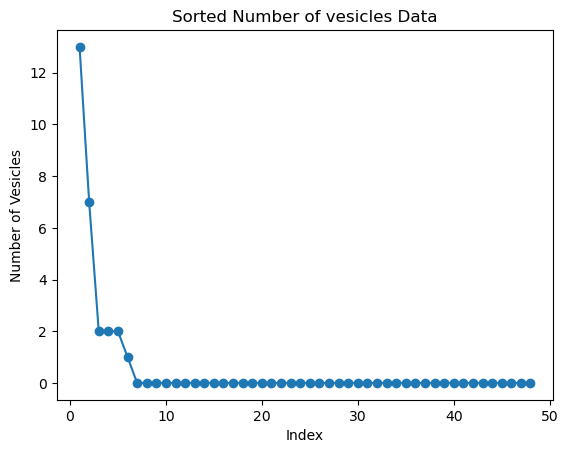

In [19]:
# Sort the DataFrame based on the "area_percent" column
df_sorted = df_input.sort_values(by="num_vesicles", ascending=False)

# Plot the sorted data
plt.plot(range(1, len(df_sorted) + 1), df_sorted["num_vesicles"], marker='o')
plt.xlabel("Index")
plt.ylabel("Number of Vesicles")
plt.title("Sorted Number of vesicles Data")
plt.show()

In [6]:
len(df_input[df_input['num_vesicles']>0])

6

In [8]:
6/48

0.125

In [20]:
# Apply log1p transformation to each value in the DataFrame
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_86386/2331498562.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.075107,0.596085,0.875469,1.056053,0.494696,0.268117,0.542324,0
1,0.266203,0.832909,1.238374,0.314811,0.810930,0.483968,0.354172,0
2,1.056053,0.202941,0.690644,1.749200,0.026642,0.750236,0.491643,1
3,0.157858,1.531476,0.158712,0.503801,0.906240,0.684359,0.084341,0
4,1.002468,0.135405,0.491643,1.481605,0.178983,0.255417,0.371564,0
5,0.103459,1.341558,0.788457,1.208960,0.123986,0.563892,0.428530,0
6,0.125751,0.604316,1.504077,0.864997,0.506818,0.625938,0.509825,0
7,0.107059,0.491643,1.170933,0.428530,0.926241,0.888920,0.565314,0
8,0.071390,1.193922,1.081805,0.983949,0.239017,0.058269,0.385262,0
9,1.139434,0.579418,0.121332,0.993252,0.219136,0.355925,0.398776,0


In [21]:
df_input.to_csv('../../data/20240517/df_input_20240518.csv', index=False)

In [22]:
df_input_init = pd.read_csv('../../data/20240503/df_input_update_20240511.csv')

In [25]:
df_input_init = df_input_init.rename(columns={
    'Total_decanoic acid_Mass': 'decanoic acid_Concentration (mM)',
    'Total_decanoate_Mass': 'decanoate_Concentration (mM)',
    'Total_decylamine_Mass': 'decylamine_Concentration (mM)',
    'Total_decyl trimethylamine_Mass': 'decyl trimethylamine_Concentration (mM)',
    'Total_decylsulfate_Mass': 'decylsulfate_Concentration (mM)',
    'Total_decanol_Mass': 'decanol_Concentration (mM)',
    'Total_monocaprin_Mass': 'monocaprin_Concentration (mM)',
    'num_vesicles': 'num_vesicles'
})

In [26]:
df_input_update = pd.concat([df_input_init, df_input])
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
43,0.106160,1.315067,1.791759,0.916291,0.239017,0.371564,0.254642,0
44,0.418710,0.242946,1.423108,0.125751,1.056053,0.767791,0.307485,0
45,0.254642,0.288931,1.090244,1.638997,0.254642,0.426900,0.509825,7
46,0.753772,1.695616,1.648659,0.039221,0.006976,0.016365,0.117783,0


In [28]:
df_input_update.to_csv('../../data/20240517/df_input_update_20240518.csv', index = False)

In [2]:
df_input_update=pd.read_csv('../../data/20240517/df_input_update_20240518.csv')
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
139,0.106160,1.315067,1.791759,0.916291,0.239017,0.371564,0.254642,0
140,0.418710,0.242946,1.423108,0.125751,1.056053,0.767791,0.307485,0
141,0.254642,0.288931,1.090244,1.638997,0.254642,0.426900,0.509825,7
142,0.753772,1.695616,1.648659,0.039221,0.006976,0.016365,0.117783,0


In [3]:
df_input_update['num_vesicles'] = df_input_update['num_vesicles'].apply(lambda x: 0 if x < 1 else 1)
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,1
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,1
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,1
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,1
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,1
...,...,...,...,...,...,...,...,...
139,0.106160,1.315067,1.791759,0.916291,0.239017,0.371564,0.254642,0
140,0.418710,0.242946,1.423108,0.125751,1.056053,0.767791,0.307485,0
141,0.254642,0.288931,1.090244,1.638997,0.254642,0.426900,0.509825,1
142,0.753772,1.695616,1.648659,0.039221,0.006976,0.016365,0.117783,0


In [4]:
# data already done the log1p transform
X = df_input_update.iloc[:,0:7].values
y = df_input_update.iloc[:,-1:].values.ravel()

Iteration 1: Training Accuracy = 0.8261, Test Accuracy = 0.9655
Iteration 2: Training Accuracy = 0.9304, Test Accuracy = 0.6552
Iteration 3: Training Accuracy = 0.8435, Test Accuracy = 0.7586
Iteration 4: Training Accuracy = 0.8435, Test Accuracy = 0.7931
Iteration 5: Training Accuracy = 0.8870, Test Accuracy = 0.8276
Iteration 6: Training Accuracy = 0.8957, Test Accuracy = 0.7586
Iteration 7: Training Accuracy = 0.8522, Test Accuracy = 0.8276
Iteration 8: Training Accuracy = 0.8609, Test Accuracy = 0.8276
Iteration 9: Training Accuracy = 0.8609, Test Accuracy = 0.8621
Iteration 10: Training Accuracy = 0.8696, Test Accuracy = 0.8276


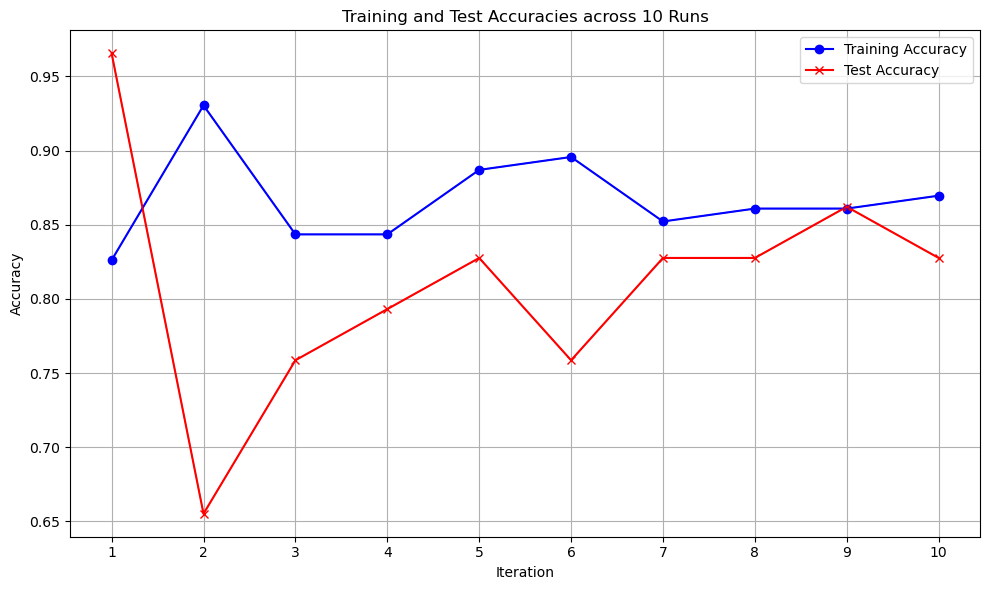

In [61]:

train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the training accuracy
plt.plot(range(1, 11), train_accuracies, marker='o', color='blue', label='Training Accuracy')

# Plotting the test accuracy
plt.plot(range(1, 11), test_accuracies, marker='x', color='red', label='Test Accuracy')

# Connecting scatter points with lines
plt.plot(range(1, 11), train_accuracies, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.plot(range(1, 11), test_accuracies, color='red', linewidth=1, linestyle='-', alpha=0.5)

# Adding labels and title
plt.title('Training and Test Accuracies across 10 Runs')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Calculate the average and standard deviation of training and testing accuracies
average_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"\nAverage Training Accuracy: {average_train_accuracy:.4f}")
print(f"Training Accuracy Standard Deviation: {std_train_accuracy:.4f}")
print(f"Average Test Accuracy: {average_test_accuracy:.4f}")
print(f"Test Accuracy Standard Deviation: {std_test_accuracy:.4f}")


Iteration 1: Training Accuracy = 0.8261, Test Accuracy = 0.9655
Iteration 2: Training Accuracy = 0.9304, Test Accuracy = 0.6552
Iteration 3: Training Accuracy = 0.8435, Test Accuracy = 0.7586
Iteration 4: Training Accuracy = 0.8435, Test Accuracy = 0.7931
Iteration 5: Training Accuracy = 0.8870, Test Accuracy = 0.8276
Iteration 6: Training Accuracy = 0.8957, Test Accuracy = 0.7586
Iteration 7: Training Accuracy = 0.8522, Test Accuracy = 0.8276
Iteration 8: Training Accuracy = 0.8609, Test Accuracy = 0.8276
Iteration 9: Training Accuracy = 0.8609, Test Accuracy = 0.8621
Iteration 10: Training Accuracy = 0.8696, Test Accuracy = 0.8276

Average Training Accuracy: 0.8670
Training Accuracy Standard Deviation: 0.0289
Average Test Accuracy: 0.8103
Test Accuracy Standard Deviation: 0.0759


In [62]:
# working on whole dagtaset to get final model
kernel = 1.0 * RBF(1)
model = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)

model.score(X, y)

0.8541666666666666

In [96]:
# Save the model to a file
with open('../../data/20240517/model/GPC_model_20240520.pkl', 'wb') as file:
    pickle.dump(model, file)

In [8]:
model.kernel_.get_params()

{'k1': 8.23**2,
 'k2': RBF(length_scale=4.39),
 'k1__constant_value': 67.79619511865022,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 4.3930279653025055,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

In [48]:
# Using half input space

In [47]:
bounds = torch.tensor([[0., 0., 0., 0., 0., 0., 0.],[2.5, 2.5, 2.5, 2.5, 2.5, 0.75, 0.5]])
bounds = torch.log1p(bounds)
# Sample points in the 7-dimensional space
num_samples = 10000000
num_dimensions = bounds.shape[1]
samples = torch.rand(num_samples, num_dimensions) 

# Scale the samples to the specified bounds
scaled_samples = samples * (bounds[1] - bounds[0]) + bounds[0]

# Now scaled_samples contains the sampled points in the specified bounds
scaled_samples

tensor([[0.5670, 0.6972, 0.3813,  ..., 0.3019, 0.5436, 0.1900],
        [0.8937, 0.8523, 0.7595,  ..., 1.2010, 0.4537, 0.1512],
        [0.4182, 0.1771, 1.0370,  ..., 0.8230, 0.1311, 0.2929],
        ...,
        [0.9694, 1.0664, 0.4404,  ..., 1.2173, 0.2188, 0.3154],
        [0.8776, 1.1431, 0.1489,  ..., 0.7524, 0.2022, 0.0902],
        [0.6834, 0.3079, 0.5977,  ..., 0.0991, 0.1594, 0.3359]])

In [57]:
df_sample = pd.DataFrame(scaled_samples, columns=[df_input_update.iloc[:,0:-1].columns])

In [58]:
start_time = time.time()

# Your code snippet
pred_prob = model.predict_proba(df_sample.values)

# Record end time
end_time = time.time()

# Calculate running time
running_time = end_time - start_time
print("Running time:", running_time, "seconds")

Running time: 319.49656796455383 seconds


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

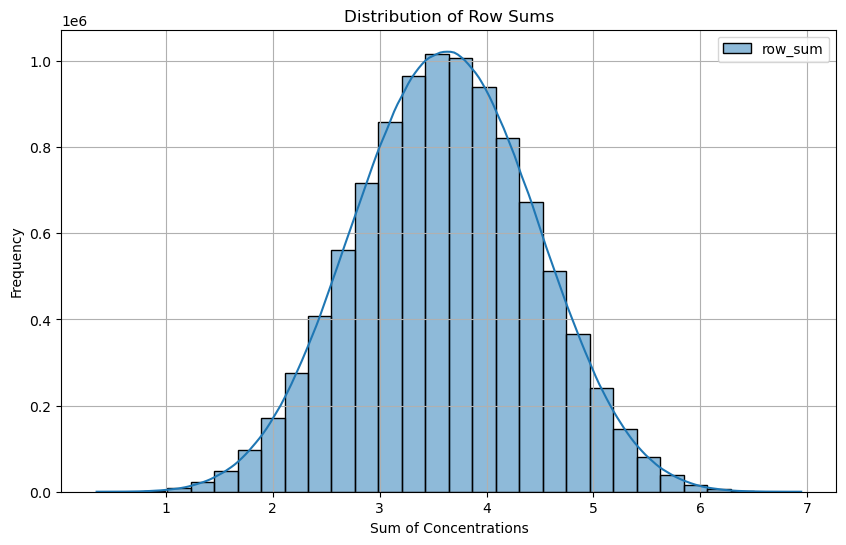

In [65]:
# Calculate the sum of each row
df_sample['row_sum'] = df_sample.sum(axis=1)

# Plotting the distribution of row sums
plt.figure(figsize=(10, 6))
sns.histplot(df_sample['row_sum'], kde=True, bins=30, color='blue')
plt.title('Distribution of Row Sums')
plt.xlabel('Sum of Concentrations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [66]:
entropy_value = cal_entropy(pred_prob)
# Get indices of the first 48 samples with highest entropy
top_indices = np.argsort(entropy_value)[::-1][:48]
top_indices

array([8852806, 9577514, 7388772, 4057169, 6342456, 3749930, 8392172,
       4379255, 6239760, 7312913, 4380412, 2033528, 5923656, 9272102,
       5454126, 6770951, 6114380, 4998450, 9839967, 5656611, 3871603,
       4799423, 7336861, 5809687,  342951, 4455101, 8277967, 1748978,
       5715687, 1188273,  106441, 6972359,  121652, 2128164, 3494816,
       7686599, 8503542,  152327, 9188110, 4179514, 5170053, 6429040,
       2805086, 4819517, 5949074, 7490357, 3157202, 7161630])

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel="('row_sum',)", ylabel='Count'>

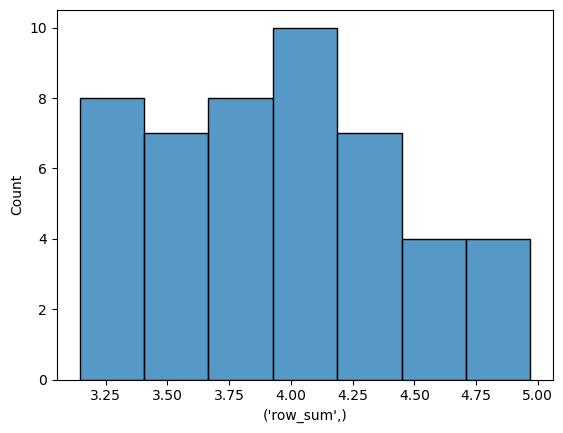

In [67]:
sns.histplot(df_sample.iloc[top_indices].iloc[:,-1])

In [68]:
df_sample.to_csv('df_sample_20240520.csv', index=False)

In [71]:
df_prob = pd.DataFrame(pred_prob)
df_prob.to_csv('pred_prob_20240520.csv', index=False)

In [75]:
df_sample = df_sample.iloc[:, 0:-1]

In [97]:
np.log1p(0.979345)

0.6827659818965724

In [101]:
np.expm1(0.6827659818965724)

0.979345

In [76]:
candidates = df_sample.iloc[top_indices]
original_scale_df = np.expm1(candidates)
original_scale_df

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
8852806,0.979345,0.368779,0.140670,0.839524,2.412342,0.392101,0.061957
9577514,1.931462,1.224442,1.300719,0.773811,1.389035,0.640298,0.050809
7388772,2.392485,0.145693,0.083322,0.739851,1.331448,0.165722,0.492229
4057169,1.513281,0.958422,1.092920,0.644299,1.239800,0.212365,0.461042
6342456,1.751293,1.649701,0.014303,0.394923,2.239847,0.546598,0.032294
3749930,1.451201,2.382975,0.187890,1.479317,0.896171,0.508413,0.264009
8392172,2.201661,1.020112,0.019511,0.474590,1.686422,0.084610,0.141979
4379255,1.974665,0.947209,1.629162,0.139486,2.007896,0.367653,0.065087
6239760,1.969710,0.575035,0.467223,0.430116,1.701249,0.593875,0.450245
7312913,2.462735,2.211668,0.605202,0.640979,0.752211,0.068177,0.350852


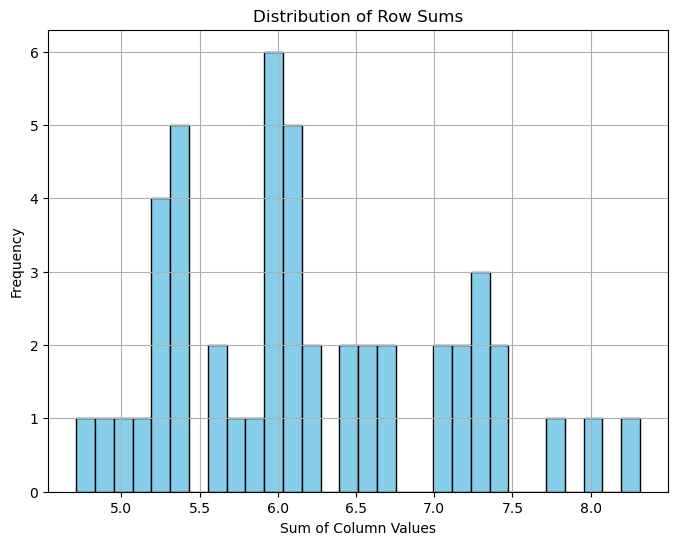

In [77]:
row_sums = original_scale_df.sum(axis=1)

# Plot the distribution
plt.figure(figsize=(8, 6))
plt.hist(row_sums, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Row Sums')
plt.xlabel('Sum of Column Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [78]:
candidates.to_csv('candidates_20240520.csv', index = False)

In [18]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)

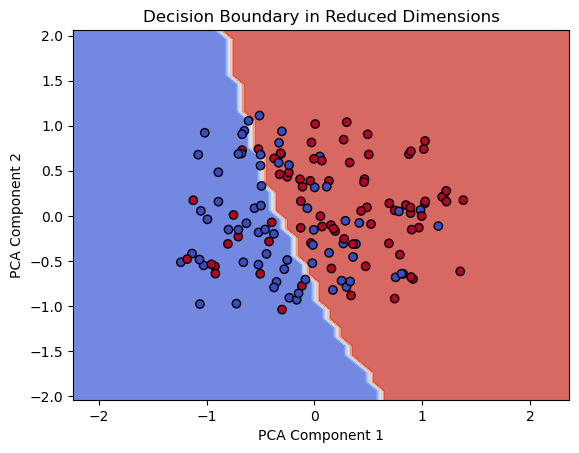

In [19]:
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot decision boundary and data points
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
plt.show()

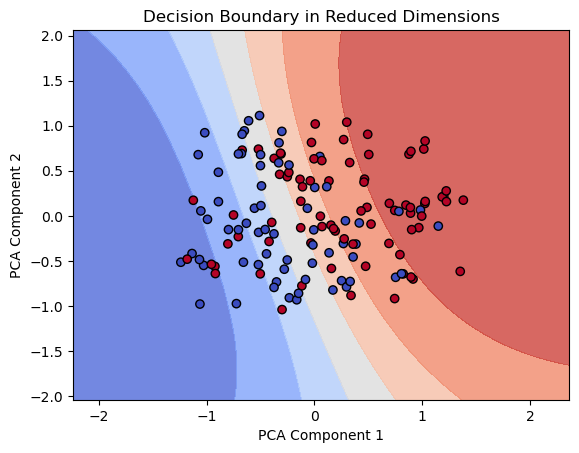

In [35]:
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
# Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
# Z = Z.reshape(xx.shape)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_original_space = pca.inverse_transform(grid_points)
probs = model.predict_proba(grid_points_original_space)
probs_class_1 = probs[:, 1].reshape(xx.shape)

# Plot decision boundary and data points
plt.contourf(xx, yy, probs_class_1, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
plt.show()

In [7]:
pca = PCA()
X_reduced = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.28086498, 0.19727009, 0.18831616, 0.1549008 , 0.11907401,
       0.04336768, 0.01620627])

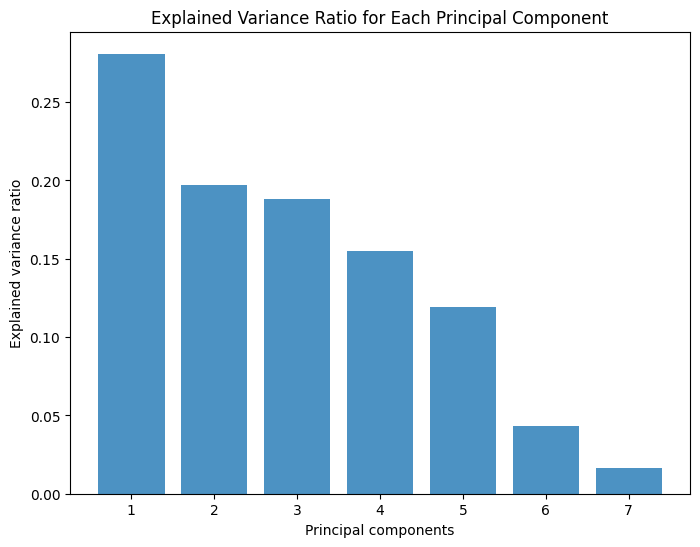

In [8]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio for each PC
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Explained Variance Ratio for Each Principal Component')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.show()

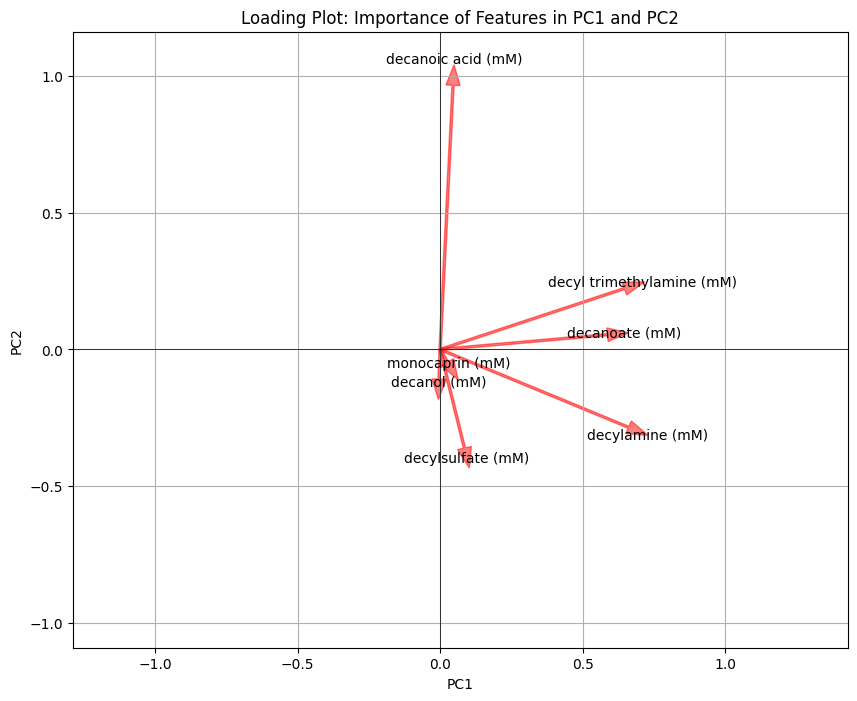

In [9]:
# Get the loadings for the first two PCs
loadings = pca.components_[:2, :]

# Feature names
feature_names = ['decanoic acid (mM)', 'decanoate (mM)',
                 'decylamine (mM)', 'decyl trimethylamine (mM)',
                 'decylsulfate (mM)', 'decanol (mM)',
                 'monocaprin (mM)']

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)

# Plot loadings with arrows
plt.figure(figsize=(10, 8))
plt.title('Loading Plot: Importance of Features in PC1 and PC2')

# Scale factor for the arrows to make them visually appealing
scale_factor = 1.1

for feature in loadings_df.index:
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1'] * scale_factor, loadings_df.loc[feature, 'PC2'] * scale_factor,
              color='r', alpha=0.5, width=0.008, head_width=0.05)
    plt.text(loadings_df.loc[feature, 'PC1'] * scale_factor * 1.1, loadings_df.loc[feature, 'PC2'] * scale_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Set x and y limits based on PC1 and PC2 range
pc1_min, pc1_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
pc2_min, pc2_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
plt.xlim(pc1_min - 0.05, pc1_max + 0.05)
plt.ylim(pc2_min - 0.05, pc2_max + 0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [20]:
pca.explained_variance_ratio_

array([0.28086498, 0.19727009])

In [79]:
entropy_value

array([0.30250926, 0.92318677, 0.96929799, ..., 0.35333592, 0.83035363,
       0.34142786])

In [80]:
entropy_value.sum()

6753653.153610268

### Create dispense volume

In [81]:
original_scale_df.to_csv('original_scale_df_GPC_20240520.csv', index=False)

In [83]:
solutes = ['decanoic acid', 'decanoate', 'decylamine', 'decyl trimethylamine', 'decylsulfate', 'decanol', 'monocaprin']
dispense_df = get_dispense_volume(original_scale_df, solutes, allow_zero=True)
len(dispense_df)

48

In [87]:
def clean_column_name(name):
    return name.replace("('", "").replace("_Concentration (mM)',) ", "_Concentration ")

# Apply the function to the column names
dispense_df.columns = [clean_column_name(col) for col in dispense_df.columns]
dispense_df.columns

Index(['decanoic acid_Concentration (50 mM)',
       'decanoic acid_Concentration (10 mM)',
       'decanoic acid_Concentration (2 mM)', 'decanoate_Concentration (50 mM)',
       'decanoate_Concentration (10 mM)', 'decanoate_Concentration (2 mM)',
       'decylamine_Concentration (50 mM)', 'decylamine_Concentration (10 mM)',
       'decylamine_Concentration (2 mM)',
       'decyl trimethylamine_Concentration (50 mM)',
       'decyl trimethylamine_Concentration (10 mM)',
       'decyl trimethylamine_Concentration (2 mM)',
       'decylsulfate_Concentration (50 mM)',
       'decylsulfate_Concentration (10 mM)',
       'decylsulfate_Concentration (2 mM)', 'decanol_Concentration (15 mM)',
       'decanol_Concentration (3 mM)', 'monocaprin_Concentration (10 mM)',
       'monocaprin_Concentration (2 mM)'],
      dtype='object')

In [89]:
dispense_df.to_csv('dispense_df_GPC_20240520.csv', index=False)

In [92]:
# Repeat the dataframe to have 96 rows
df_repeated = pd.concat([dispense_df] * 2, ignore_index=True)

# Create Labware_Deck_Slot column
df_repeated['Labware_Deck_Slot'] = [1] * 48 + [2] * 48

# Create Destination_Well column based on the well pattern
destination_well = []

for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    for i in range(1, 13):
        destination_well.append(f"{letter}{i}")

df_repeated['Destination_Well'] = destination_well

# Rearrange columns
df_repeated = df_repeated[['Labware_Deck_Slot', 'Destination_Well'] + list(dispense_df.columns)]

# Save to Excel with two sheets
with pd.ExcelWriter('../../data/20240517/dispense_df_20240520.xlsx') as writer:
    # Write df_repeated to sheet Plate1
    df_repeated.to_excel(writer, sheet_name='Plate1', index=False)
    
    # Write df_repeated to sheet Plate2
    df_repeated.to_excel(writer, sheet_name='Plate2', index=False)

In [93]:
dispense_df

,decanoic acid_Concentration (50 mM),decanoic acid_Concentration (10 mM),decanoic acid_Concentration (2 mM),decanoate_Concentration (50 mM),decanoate_Concentration (10 mM),decanoate_Concentration (2 mM),decylamine_Concentration (50 mM),decylamine_Concentration (10 mM),decylamine_Concentration (2 mM),decyl trimethylamine_Concentration (50 mM),decyl trimethylamine_Concentration (10 mM),decyl trimethylamine_Concentration (2 mM),decylsulfate_Concentration (50 mM),decylsulfate_Concentration (10 mM),decylsulfate_Concentration (2 mM),decanol_Concentration (15 mM),decanol_Concentration (3 mM),monocaprin_Concentration (10 mM),monocaprin_Concentration (2 mM)
8852806,0.0,19.6,0.0,0.0,7.4,0.0,0.0,0.0,14.1,0.0,16.8,0.0,9.6,0.0,0.0,5.2,0.0,0.0,6.2
9577514,7.7,0.0,0.0,4.9,0.0,0.0,5.2,0.0,0.0,0.0,15.5,0.0,5.6,0.0,0.0,8.5,0.0,0.0,5.1
7388772,9.6,0.0,0.0,0.0,0.0,14.6,0.0,0.0,8.3,0.0,14.8,0.0,5.3,0.0,0.0,0.0,11.0,9.8,0.0
4057169,6.1,0.0,0.0,0.0,19.2,0.0,4.4,0.0,0.0,0.0,12.9,0.0,5.0,0.0,0.0,0.0,14.2,9.2,0.0
6342456,7.0,0.0,0.0,6.6,0.0,0.0,0.0,0.0,1.4,0.0,7.9,0.0,9.0,0.0,0.0,7.3,0.0,0.0,3.2
3749930,5.8,0.0,0.0,9.5,0.0,0.0,0.0,0.0,18.8,5.9,0.0,0.0,0.0,17.9,0.0,6.8,0.0,5.3,0.0
8392172,8.8,0.0,0.0,4.1,0.0,0.0,0.0,0.0,2.0,0.0,9.5,0.0,6.7,0.0,0.0,0.0,5.6,0.0,14.2
4379255,7.9,0.0,0.0,0.0,18.9,0.0,6.5,0.0,0.0,0.0,0.0,13.9,8.0,0.0,0.0,4.9,0.0,0.0,6.5
6239760,7.9,0.0,0.0,0.0,11.5,0.0,0.0,9.3,0.0,0.0,8.6,0.0,6.8,0.0,0.0,7.9,0.0,9.0,0.0
7312913,9.9,0.0,0.0,8.8,0.0,0.0,0.0,12.1,0.0,0.0,12.8,0.0,0.0,15.0,0.0,0.0,4.5,7.0,0.0
